### Stock Market Prediction And Forecasting Using Stacked LSTM

In [2]:
### Data Collection
import pandas_datareader as pdr
key="dbb69f9d7b165d46474fca887d8d57bbec8ecf31"

In [3]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

C:\Users\91943\anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd

In [6]:
df=pd.read_csv('AAPL.csv')

In [7]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-01-30 00:00:00+00:00,121.63,121.63,120.66,120.930,30377503,28.618590,28.618590,28.390356,28.453885,121510012,0.0,1.0
1,AAPL,2017-01-31 00:00:00+00:00,121.35,121.39,120.62,121.150,49200993,28.552708,28.562120,28.380945,28.505650,196803972,0.0,1.0
2,AAPL,2017-02-01 00:00:00+00:00,128.75,130.49,127.01,127.030,111985040,30.293870,30.703279,29.884462,29.889168,447940160,0.0,1.0
3,AAPL,2017-02-02 00:00:00+00:00,128.53,129.39,127.78,127.975,33710411,30.242106,30.444457,30.065637,30.111519,134841644,0.0,1.0
4,AAPL,2017-02-03 00:00:00+00:00,129.08,129.19,128.16,128.310,24507301,30.371517,30.397399,30.155048,30.190342,98029204,0.0,1.0


In [8]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1254,AAPL,2022-01-21 00:00:00+00:00,162.41,166.3300,162.30,164.415,122848858,162.41,166.3300,162.30,164.415,122848858,0.0,1.0
1255,AAPL,2022-01-24 00:00:00+00:00,161.62,162.3000,154.70,160.020,162706686,161.62,162.3000,154.70,160.020,162706686,0.0,1.0
1256,AAPL,2022-01-25 00:00:00+00:00,159.78,162.7600,157.02,158.980,115798367,159.78,162.7600,157.02,158.980,115798367,0.0,1.0
1257,AAPL,2022-01-26 00:00:00+00:00,159.69,164.3894,157.82,163.500,108275308,159.69,164.3894,157.82,163.500,108275308,0.0,1.0
1258,AAPL,2022-01-27 00:00:00+00:00,159.22,163.8400,158.28,162.450,121954638,159.22,163.8400,158.28,162.450,121954638,0.0,1.0


In [9]:
## Selecting the 'close' column for our forecasting
df1=df.reset_index()['close']

In [10]:
df1

0       121.63
1       121.35
2       128.75
3       128.53
4       129.08
         ...  
1254    162.41
1255    161.62
1256    159.78
1257    159.69
1258    159.22
Name: close, Length: 1259, dtype: float64

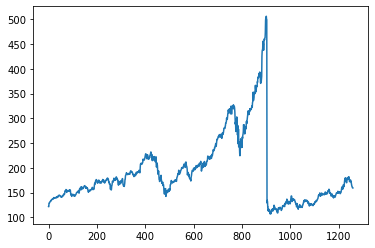

In [14]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [291]:
### Note: LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [15]:
import numpy as np

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [17]:
print(df1)

[[0.03704446]
 [0.03634314]
 [0.0548779 ]
 ...
 [0.13259862]
 [0.1323732 ]
 [0.13119599]]


In [18]:
##splitting Dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [19]:
training_size,test_size

(818, 441)

In [21]:
train_data[0:5,]

array([[0.03704446],
       [0.03634314],
       [0.0548779 ],
       [0.05432686],
       [0.05570445]])

In [22]:
import numpy
# convert an array of values into a Dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, dataX:0,1,2,3-----99   dataY:100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
print(X_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [25]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [26]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [306]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 196ms/step - loss: 0.0157 - val_loss: 0.0019
Epoch 2/100
12/12 [==============================] - 2s 141ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 3/100
12/12 [==============================] - 2s 140ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 4/100
12/12 [==============================] - 2s 142ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/100
12/12 [==============================] - 2s 141ms/step - loss: 0.0011 - val_loss: 9.6323e-04
Epoch 6/100
12/12 [==============================] - 2s 141ms/step - loss: 9.1964e-04 - val_loss: 9.1259e-04
Epoch 7/100
12/12 [==============================] - 2s 136ms/step - loss: 8.5536e-04 - val_loss: 7.1605e-04
Epoch 8/100
12/12 [==============================] - 2s 133ms/step - loss: 8.2182e-04 - val_loss: 5.1953e-04
Epoch 9/100
12/12 [==============================] - 2s 134ms/step - loss: 7.7089e-04 - val_loss: 3.9140e-04
Epoch 10/100
12/12 [==============================] - 2

Epoch 76/100
12/12 [==============================] - 2s 135ms/step - loss: 2.8855e-04 - val_loss: 2.8772e-04
Epoch 77/100
12/12 [==============================] - 2s 134ms/step - loss: 2.8706e-04 - val_loss: 2.6504e-04
Epoch 78/100
12/12 [==============================] - 2s 135ms/step - loss: 3.1070e-04 - val_loss: 2.4767e-04
Epoch 79/100
12/12 [==============================] - 2s 138ms/step - loss: 3.0830e-04 - val_loss: 2.1404e-04
Epoch 80/100
12/12 [==============================] - 2s 138ms/step - loss: 2.9686e-04 - val_loss: 3.2362e-04
Epoch 81/100
12/12 [==============================] - 2s 136ms/step - loss: 2.9803e-04 - val_loss: 2.4956e-04
Epoch 82/100
12/12 [==============================] - 2s 138ms/step - loss: 3.1804e-04 - val_loss: 2.5058e-04
Epoch 83/100
12/12 [==============================] - 2s 135ms/step - loss: 3.4294e-04 - val_loss: 2.8743e-04
Epoch 84/100
12/12 [==============================] - 2s 141ms/step - loss: 3.4311e-04 - val_loss: 1.8999e-04
Epoch 85/1

In [31]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [32]:
### Lets Do the prediction and check Performance Metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [33]:
##Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [34]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

205.94626188200397

In [35]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

141.12779176881622

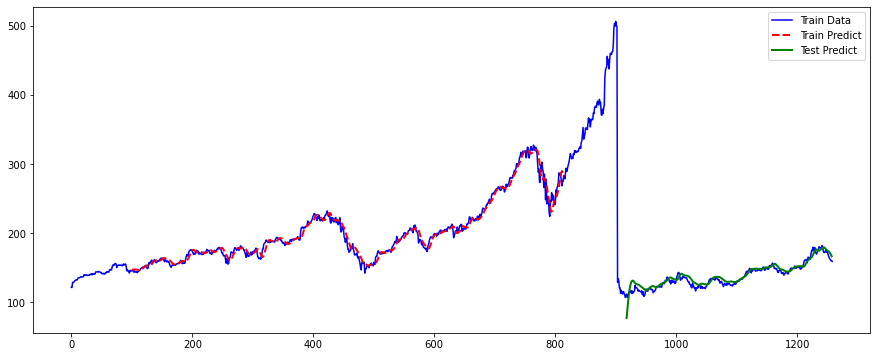

In [55]:
### Plotting Data
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(df1), '-b', label='Train Data')
plt.plot(trainPredictPlot,'--r', label='Train Predict',linewidth=2.0)
plt.plot(testPredictPlot,'g', label='Test Predict', linewidth=2.0)
leg = plt.legend();
plt.show()

### Predicting Next 30 days

In [56]:
len(test_data)

441

In [57]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [58]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [60]:
temp_input[0:5]

[0.12485911083281148,
 0.12090169067000628,
 0.11829680651221036,
 0.1055228553537883,
 0.10697557921102063]

In [61]:
# Demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.14201552]
101
1 day input [0.12090169 0.11829681 0.10552286 0.10697558 0.10339386 0.10567314
 0.10507201 0.09823419 0.09041954 0.09164684 0.0977082  0.10016281
 0.10038823 0.09650595 0.0878397  0.09014402 0.08681277 0.08969317
 0.08090169 0.08583594 0.08806512 0.09129618 0.09031935 0.09009393
 0.08683782 0.085335   0.09247339 0.09517846 0.09946149 0.10499687
 0.10624922 0.10680025 0.10482154 0.10469631 0.1063995  0.10522229
 0.11453976 0.10760175 0.10549781 0.10815279 0.11183469 0.1105072
 0.1113087  0.10920476 0.1101315  0.10289292 0.10276769 0.10807765
 0.10810269 0.11060739 0.11684408 0.12781465 0.13452724 0.13570445
 0.13668128 0.13800877 0.12515967 0.13375078 0.14642455 0.14509706
 0.14256731 0.1377583  0.14647464 0.16115216 0.17092048 0.16961803
 0.181866   0.17257358 0.16904195 0.18149029 0.16385723 0.16105197
 0.15757044 0.16568566 0.17232311 0.17392611 0.18407013 0.18146525
 0.18169067 0.17873513 0.17715717 0.18827802 0.18249217 0.17051972
 0.16320601 0.16363181 0.1636819  

10 day output [[0.14501178]]
11 day input [0.0977082  0.10016281 0.10038823 0.09650595 0.0878397  0.09014402
 0.08681277 0.08969317 0.08090169 0.08583594 0.08806512 0.09129618
 0.09031935 0.09009393 0.08683782 0.085335   0.09247339 0.09517846
 0.09946149 0.10499687 0.10624922 0.10680025 0.10482154 0.10469631
 0.1063995  0.10522229 0.11453976 0.10760175 0.10549781 0.10815279
 0.11183469 0.1105072  0.1113087  0.10920476 0.1101315  0.10289292
 0.10276769 0.10807765 0.10810269 0.11060739 0.11684408 0.12781465
 0.13452724 0.13570445 0.13668128 0.13800877 0.12515967 0.13375078
 0.14642455 0.14509706 0.14256731 0.1377583  0.14647464 0.16115216
 0.17092048 0.16961803 0.181866   0.17257358 0.16904195 0.18149029
 0.16385723 0.16105197 0.15757044 0.16568566 0.17232311 0.17392611
 0.18407013 0.18146525 0.18169067 0.17873513 0.17715717 0.18827802
 0.18249217 0.17051972 0.16320601 0.16363181 0.1636819  0.17092048
 0.17204759 0.1636819  0.16588604 0.15769568 0.14875391 0.14444584
 0.13918597 0.137207

20 day output [[0.15360624]]
21 day input [0.08806512 0.09129618 0.09031935 0.09009393 0.08683782 0.085335
 0.09247339 0.09517846 0.09946149 0.10499687 0.10624922 0.10680025
 0.10482154 0.10469631 0.1063995  0.10522229 0.11453976 0.10760175
 0.10549781 0.10815279 0.11183469 0.1105072  0.1113087  0.10920476
 0.1101315  0.10289292 0.10276769 0.10807765 0.10810269 0.11060739
 0.11684408 0.12781465 0.13452724 0.13570445 0.13668128 0.13800877
 0.12515967 0.13375078 0.14642455 0.14509706 0.14256731 0.1377583
 0.14647464 0.16115216 0.17092048 0.16961803 0.181866   0.17257358
 0.16904195 0.18149029 0.16385723 0.16105197 0.15757044 0.16568566
 0.17232311 0.17392611 0.18407013 0.18146525 0.18169067 0.17873513
 0.17715717 0.18827802 0.18249217 0.17051972 0.16320601 0.16363181
 0.1636819  0.17092048 0.17204759 0.1636819  0.16588604 0.15769568
 0.14875391 0.14444584 0.13918597 0.13720726 0.13259862 0.1323732
 0.13119599 0.14201552 0.13978207 0.1387915  0.13868538 0.13913403
 0.13990104 0.14083736 0

In [62]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [63]:
import matplotlib.pyplot as plt

In [64]:
len(df1)

1259

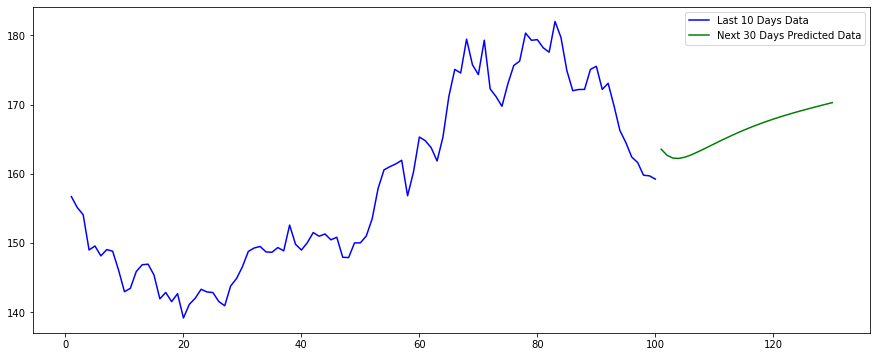

In [66]:
plt.figure(figsize=(15,6))
plt.plot(day_new,scaler.inverse_transform(df1[1159:]),'b', label='Last 10 Days Data')
plt.plot(day_pred,scaler.inverse_transform(lst_output),'g', label='Next 30 Days Predicted Data')
leg = plt.legend();
plt.show()

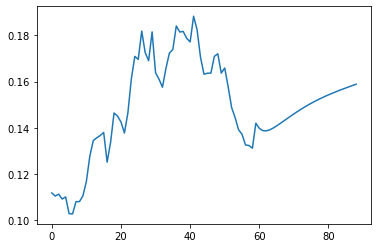

In [67]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [395]:
df3=scaler.inverse_transform(df3).tolist()

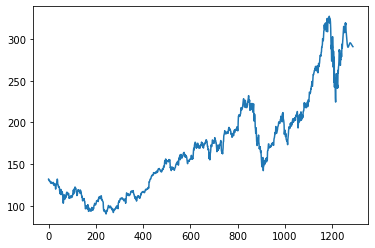

In [396]:
plt.plot(df3)